In [1]:
import os, sys
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from util import basic


In [2]:
pos_data, pos_label = basic.preprocess_data("/home/moamin/sequence_annotation_seawulf/gene_range_start_codon.txt", 1)
neg_data, neg_label = basic.preprocess_data("/home/moamin/sequence_annotation_seawulf/intragenic_start_codon.txt", 0)

In [3]:
print(len(pos_data), len(neg_data))
print(pos_label[0], neg_label[0])
data_size = 500
batch_size = 1000

8385 13683
1 0


In [4]:
data_content = pos_data[:data_size] + neg_data[:data_size]
data_label = pos_label[:data_size] + neg_label[:data_size] 
print(len(data_content), np.sum(data_label))

rand_index = np.random.permutation(len(data_content))
data_content = [data_content[i] for i in rand_index]
data_label = [data_label[i] for i in rand_index]
print(len(data_content), np.sum(data_label))
'''
for i in range(len(data_label)):
    if data_label[i] == 1:
        data_content[i] = [data_content[i][0] for k in data_content[i]]
'''

1000 500
1000 500


'\nfor i in range(len(data_label)):\n    if data_label[i] == 1:\n        data_content[i] = [data_content[i][0] for k in data_content[i]]\n'

In [5]:
np.array(data_content)

array([['4', '1', '4', ..., '1', '1', '2'],
       ['3', '4', '2', ..., '1', '1', '1'],
       ['2', '3', '2', ..., '4', '2', '3'],
       ...,
       ['2', '1', '1', ..., '1', '2', '1'],
       ['1', '4', '4', ..., '4', '1', '1'],
       ['3', '1', '3', ..., '2', '1', '4']], dtype='<U1')

In [6]:
np.array(data_label)

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,

## Pytorch Basic Attention model

In [7]:
X = torch.from_numpy(np.array(data_content).astype(int))
Y = torch.from_numpy(np.array(data_label).reshape(len(data_label),1).astype(int))
X.shape, Y.shape

(torch.Size([1000, 101]), torch.Size([1000, 1]))

In [96]:
class AttnDecoderRNN(nn.Module):#corrected batch faster
    #(self, time_steps, embedding_dim, hidden_dim, vocab_size, tagset_size, mini_batch)
    def __init__(self, vocab_size, embedding_dim, \
                 hidden_size, batch_size=100, \
                 tagset_size=1, time_steps=101):
        super(AttnDecoderRNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.time_steps = time_steps
        self.hidden_size = hidden_size
        self.minibatch_size = batch_size
        self.dropout_p = 0.25
        self.tagset_size = tagset_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.attn_array = [nn.Linear(self.hidden_size, 1) for i in range(time_steps)]
        self.attn_combine = nn.Linear(self.hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.linear = nn.Linear(embedding_dim, 1)
        #embedding_dim*time_steps

    def forward(self, input):
        init_embed = self.embedding(input)
        embedded = init_embed.permute(1, 0, 2)
        #print("Embedding Shape: ", embedded.shape)
        #embedded = self.dropout(embedded).view(self.minibatch_size*self.time_steps,self.embedding_dim)
        #print("Embedding Shape: ", embedded[0].shape)
        
        attention = [self.attn_array[i](embedded[i][:]) \
                     for i in range(self.time_steps)]
        attention = torch.stack(attention)
        attention = attention.view(self.time_steps, -1).permute(1, 0)
        #print("Attention Shape: ", attention.shape)
        
        attn_weights = F.softmax(attention, dim=1)
        attn_weights = attn_weights.view(self.mini batch_size, self.time_steps, 1)
        #print("Softmax Shape: ", attn_weights.shape)
        
        attn_weights = torch.stack(
            [attn_weights]*self.embedding_dim, 2).view(
            self.minibatch_size, self.time_steps, -1)
        #print("Softmax ReShape: ", attn_weights.shape)
        
        #attn_applied = embedded
        attn_applied = attn_weights * init_embed
        attn_applied = attn_applied.view(self.minibatch_size, self.time_steps, -1)
        attn_applied = torch.sum(attn_applied, dim=1)
        
        #print("Embedding*Attention Shape: ", attn_applied.shape)
        
        output = F.relu(attn_applied)
        output = self.linear(output)
        #output.contiguous.view(1, -1)
        #.contiguous().view(self.mini_batch, -1)
        return output, attn_weights.view(self.minibatch_size, self.time_steps, -1)

    def init_hidden(self):
        return torch.zeros(1, 101, self.hidden_size)

In [97]:
model = AttnDecoderRNN(5, 16, 16)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

AttnDecoderRNN(
  (embedding): Embedding(5, 16)
  (attn_combine): Linear(in_features=16, out_features=16, bias=True)
  (dropout): Dropout(p=0.25)
  (linear): Linear(in_features=16, out_features=1, bias=True)
)


In [98]:
print(X[:100].shape)
with torch.no_grad():
    output, attn_weights = model(X[:100])
    print(output.shape, attn_weights.shape)

torch.Size([100, 101])
Embedding Shape:  torch.Size([101, 100, 16])
Embedding Shape:  torch.Size([100, 16])
Attention Shape:  torch.Size([100, 101])
Softmax Shape:  torch.Size([100, 101, 1])
Softmax ReShape:  torch.Size([100, 101, 16])
torch.Size([100, 1]) torch.Size([100, 101, 16])


In [ ]:
from tqdm import tqdm_notebook as tqdm
losses = []
accuracies = []
batch_size = 10
model = AttnDecoderRNN(5, 16, 16, batch_size=batch_size)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

for epoch in tqdm(range(10)):  # again, normally you would NOT do 300 epochs, it is toy data
    total_loss = 0
    total_acc = 0
    
    for index in range(0, len(X), batch_size):
        sentence = X[index : index+batch_size]#.reshape(len(X[0]))
        tags = Y[index : index+batch_size]#.reshape(len(Y[0]))
        #print(sentence.shape, tags.shape)
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        # sentence_in = prepare_sequence(sentence, word_to_ix)
        #targets = prepare_sequence(tags, tag_to_ix)
        targets = tags.float().flatten()

        # Step 3. Run our forward pass.
        tag_scores, attn_weight = model(sentence)
        tag_scores = tag_scores.flatten()
        #print(targets.shape, tag_scores.shape)
        

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = criterion(tag_scores, targets)
        total_loss += loss.data.numpy()
        
        #acc = binary_accuracy(tag_scores, targets)
        #total_acc += acc
        
        loss.backward()
        optimizer.step()
        
    #total_loss.backward()
    #opt.step()
    print(epoch, total_loss)#, total_acc)
        
    losses.append(total_loss/(len(X)))
    #accuracies.append(total_acc/(len(X)/batch_size))
        

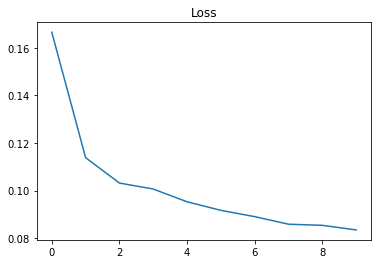

In [29]:
plt.title("Loss")
plt.plot(losses)
#plt.title("Accuracies")
#plt.plot(accuracies)

# PyTorch Implementation

In [8]:
class LSTMTagger(nn.Module):

    def __init__(self, time_steps, embedding_dim, hidden_dim, vocab_size, tagset_size, mini_batch):
        super(LSTMTagger, self).__init__()
        self.time_steps = time_steps
        self.hidden_dim = hidden_dim
        self.mini_batch = mini_batch
        self.hidden = self.init_hidden()
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm_one = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout_one = nn.Dropout(0.25)
        self.lstm_two = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout_two = nn.Dropout(0.25)

        # The linear layer that maps from hidden state space to tag space
        #self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden2tag_one = nn.Linear(hidden_dim*time_steps, 512)
        self.dropout_three = nn.Dropout(0.25)
        self.hidden2tag_two = nn.Linear(512, 128)
        self.dropout_four = nn.Dropout(0.25)
        self.hidden2tag_three = nn.Linear(128, 64)
        self.dropout_five = nn.Dropout(0.25)
        
        self.output = nn.Linear(64, tagset_size)

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, self.mini_batch, self.hidden_dim),
                torch.zeros(1, self.mini_batch, self.hidden_dim))
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)#.view(len(sentence), self.mini_batch, -1)
        lstm_out, self.hidden_one = self.lstm_one(embeds, self.hidden)
        lstm_out = self.dropout_one(lstm_out)
        lstm_out, self.hidden_two = self.lstm_two(lstm_out, self.hidden)
        lstm_out = self.dropout_two(lstm_out)
        
        #print(lstm_out.shape)
        #print(self.hidden)
        
        #print(lstm_out[:, -1].shape)
        #tag_space = self.hidden2tag(lstm_out[:, -1])
        
        lstm_out = lstm_out.contiguous().view(self.mini_batch, -1)
        #print(lstm_out.shape)
        
        
        dense_out = self.hidden2tag_one(lstm_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_three(dense_out[:])
        
        dense_out = self.hidden2tag_two(dense_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_four(dense_out[:])
        
        dense_out = self.hidden2tag_three(dense_out[:])
        dense_out = F.relu(dense_out[:])
        dense_out = self.dropout_five(dense_out[:])
        
        tag_space = self.output(dense_out[:])
        #print(tag_space.shape)
        #tag_scores = F.sigmoid(tag_space)
        #tag_scores = F.softmax(tag_space, dim=1)
        #print(tag_scores.shape)
        return tag_space


In [9]:
model = LSTMTagger(101, 16, 16, 5, 1, batch_size)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

LSTMTagger(
  (word_embeddings): Embedding(5, 16)
  (lstm_one): LSTM(16, 16, batch_first=True)
  (dropout_one): Dropout(p=0.25)
  (lstm_two): LSTM(16, 16, batch_first=True)
  (dropout_two): Dropout(p=0.25)
  (hidden2tag_one): Linear(in_features=1616, out_features=512, bias=True)
  (dropout_three): Dropout(p=0.25)
  (hidden2tag_two): Linear(in_features=512, out_features=128, bias=True)
  (dropout_four): Dropout(p=0.25)
  (hidden2tag_three): Linear(in_features=128, out_features=64, bias=True)
  (dropout_five): Dropout(p=0.25)
  (output): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
import torch.nn.functional as F

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(F.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [ ]:
from tqdm import tqdm_notebook as tqdm
losses = []
accuracies = []

for epoch in tqdm(range(10)):  # again, normally you would NOT do 300 epochs, it is toy data
    total_loss = 0
    total_acc = 0
    
    for index in range(0, len(X), batch_size):
        sentence = X[index : index+batch_size]
        tags = Y[index : index+batch_size]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        # sentence_in = prepare_sequence(sentence, word_to_ix)
        #targets = prepare_sequence(tags, tag_to_ix)
        targets = tags.float().flatten()

        # Step 3. Run our forward pass.
        tag_scores = model(sentence).flatten()
        #print(targets.shape, tag_scores.shape)
        

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = criterion(tag_scores, targets)
        total_loss += loss.data.numpy()
        
        #acc = binary_accuracy(tag_scores, targets)
        #total_acc += acc
        
        loss.backward()
        optimizer.step()
        
    #total_loss.backward()
    #opt.step()
    print(epoch, total_loss)#, total_acc)
        
    losses.append(total_loss)
    #accuracies.append(total_acc/(len(X)/batch_size))
        

0 6.926597356796265
1 6.823478877544403
2 6.113141715526581
3 5.128172338008881
4 4.144484490156174
5 3.613525301218033
6 3.318821132183075
7 3.0756156742572784
8 2.837407171726227


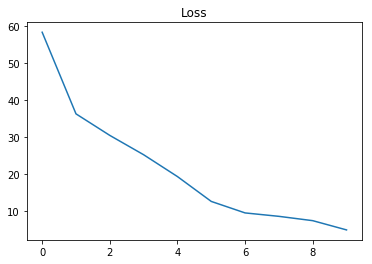

In [17]:
plt.title("Loss")
plt.plot(losses)
#plt.title("Accuracies")
#plt.plot(accuracies)

# Keras Implementation

In [ ]:
import os, sys
import random, h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD

#Initialize the Program
alphabet = "NACGT."
vocab_size = 6
embedding_size = 4
time_steps = 101
category = 2
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


In [ ]:
data_content = pos_data[:data_size] + neg_data[:data_size]
data_label = pos_label[:data_size] + neg_label[:data_size] 
print(len(data_content), np.sum(data_label))

In [ ]:
from keras.layers import Input, Embedding
from keras.layers import Reshape, Dense
from keras.models import Model

max_source_len = len(data_content[0])
embedding_size = 5
lstm_unit = 16

input_source = Input(shape=(max_source_len,), \
                     dtype='int32', name='main_input')
embedding = Embedding(input_dim=vocab_size, \
                      output_dim=embedding_size, \
                      input_length=max_source_len, \
                      name='embedding')(input_source)

lstm_layer = LSTM(lstm_unit, return_sequences=True)(embedding)
lstm_layer = Dropout(0.25)(lstm_layer)
lstm_layer = LSTM(lstm_unit, return_sequences=True)(lstm_layer)
lstm_layer = Dropout(0.25)(lstm_layer)

reshape_layer = Reshape((max_source_len*lstm_unit,))(lstm_layer)

dense_layer_first = Dense(512, activation='relu', \
                        name='fstlayer')(reshape_layer)
dense_layer_first = Dropout(0.25)(dense_layer_first)

dense_layer_mid = Dense(128, activation='relu', \
                        name='midlayer')(dense_layer_first)
dense_layer_mid = Dropout(0.25)(dense_layer_mid)

dense_layer = Dense(64, activation='relu', \
                    name='finlayer')(dense_layer_mid)
dense_layer = Dropout(0.25)(dense_layer)

dense_output = Dense(1, activation='sigmoid', \
                     name='output')(dense_layer)

model = Model(inputs=[input_source], outputs=[dense_output])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

In [ ]:
from keras_tqdm import TQDMNotebookCallback
print('Train...')

history = model.fit(np.array(data_content), np.array(data_label), \
          validation_split=0.2, shuffle=True, \
          epochs=10, batch_size=batch_size, verbose=2, \
           callbacks=[TQDMNotebookCallback()])


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
11 11


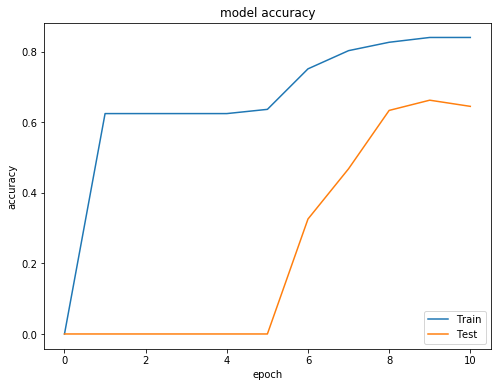

In [20]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
train = history.history['acc']
valid = history.history['val_acc']

x = [0.] + train[1:] + [train[-1]]
y = [0.] + valid[:-1] + [valid[-1]]
print(len(x), len(y))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.plot(y)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
11 11


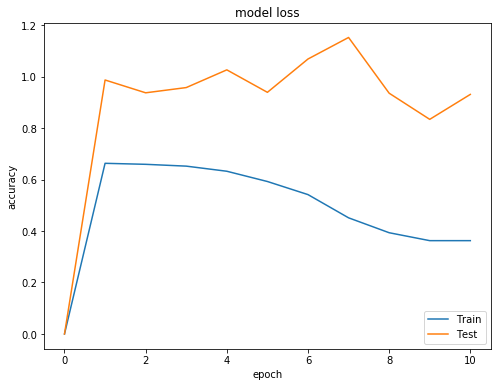

In [21]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
train = history.history['loss']
valid = history.history['val_loss']

x = [0.] + train[1:] + [train[-1]]
y = [0.] + valid[:-1] + [valid[-1]]
print(len(x), len(y))

plt.figure(figsize=(8, 6))
plt.plot(x)
plt.plot(y)
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()
